In [1]:
# Step 1: Import Required Libraries,
# The notebook starts by importing all the necessary Python libraries for:,
# Data handling → pandas, numpy,
# Machine learning → scikit-learn",
# Visualization → matplotlib, shap, plotly",
# Warnings suppression → warnings",
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold, ShuffleSplit, GridSearchCV, learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import shap
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Step 2 : Load and Prepare Dataset
# Load your input CSV file (EQUIP_Input_3.csv).
# Select the features and target variable (Ln(P)_Mpa).
# Standardize (normalize) feature values using StandardScaler.
# Split data into training (80%) and test (20%) sets.

data = pd.read_csv('data/EQUIP_Input_Mg.csv')

Features_with_XRD=['Temperature', 'CR',    
       'FIE',  'BM', 'HF', 'MV', 'Mass',  
    'M-H_Bond', 'M-H_Eng',    'formation_H', 
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix', 
      'Top_Intensity_1', 'Top_Intensity_2', 'Top_Intensity_3',
       'Top_Intensity_4', 'Top_Intensity_5', 'Top_Intensity_6',
       'Top_Intensity_7', 'Top_Intensity_8', 'Top_Intensity_9',
       'Top_Intensity_10', 'Corresponding_Angle_1', 'Corresponding_Angle_2',
       'Corresponding_Angle_3', 'Corresponding_Angle_4',
       'Corresponding_Angle_5', 'Corresponding_Angle_6',
       'Corresponding_Angle_7', 'Corresponding_Angle_8',
       'Corresponding_Angle_9', 'Corresponding_Angle_10']
scaler = StandardScaler()
data[Features_with_XRD] = scaler.fit_transform(data[Features_with_XRD])


X_XRD = data[Features_with_XRD]
y_XRD = data["Ln(P)_Mpa"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_XRD, y_XRD, test_size=0.2, random_state=10)
X_train.shape,X_test.shape

((53, 35), (14, 35))

In [4]:
# Step 3: Dataset Overview
# Total points (unique composition–temperature pairs)
# Number of unique compositions
# This gives an overview of dataset diversity and coverage.


PCTs = len(data.drop_duplicates(['composition_final', 'Temperature']))
Unique_Compositions = len(data['composition_final'].unique())
total = data.shape[0]
print("No of PCT:", PCTs, "; No of unique composition:", Unique_Compositions, "total_points:", total)


No of PCT: 67 ; No of unique composition: 19 total_points: 67


In [5]:
# Step 4: Hyperparameter Optimization (Grid Search)
# Perform a grid search using GridSearchCV to find the best combination of:
# alpha (regularization strength)
# kernel type (linear, rbf, poly)
# gamma (kernel coefficient)
# The best estimator (model configuration) is printed.

param_grid = {
    'alpha': [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5],
    'kernel': [ 'rbf'],
    'gamma': [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5]
}

grid = GridSearchCV(KernelRidge(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

KernelRidge(alpha=0.001, gamma=0.001, kernel='rbf')


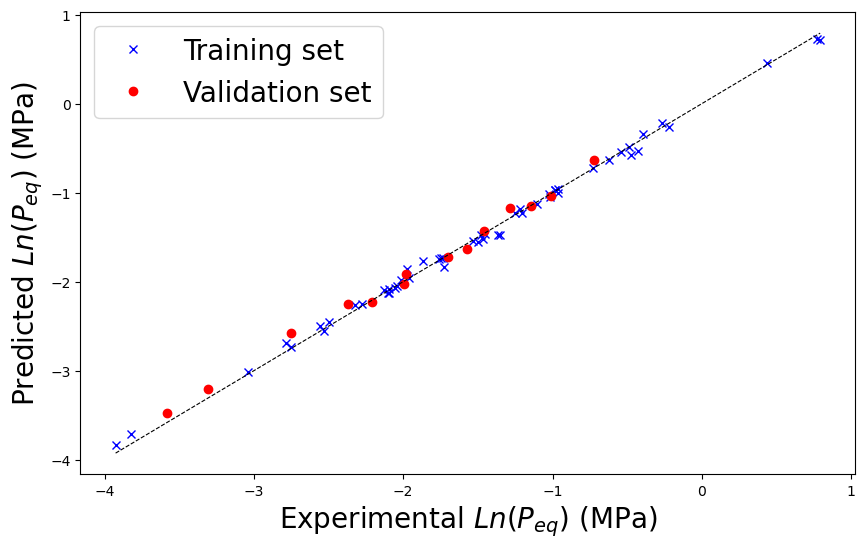

In [6]:
# Step 5: Train and Evaluate the Optimized Model
# Train the Kernel Ridge Regression (KRR) model using best hyperparameters.
# MAE (Mean Absolute Error) for train and test data
# R² Score (model fit accuracy)
# Save Parity Plot
#Visualize how well predicted values match experimental ones:
#Blue = training data
#Red = validation data
#Dashed line = perfect prediction
#This shows model accuracy visually.
kr = KernelRidge(kernel='rbf', alpha=0.001, gamma=0.001)
kr.fit(X_train, y_train)
y_train_pred = kr.predict(X_train)
y_pred = kr.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(y_train, y_train_pred, 'xb', label='Training set')
plt.plot(y_test, y_pred, 'or', label='Validation set')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=0.8, color='black')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Experimental $\\it{Ln(P_{eq})}$ (MPa)', fontsize=20)
plt.ylabel('Predicted $\\it{Ln(P_{eq})}$ (MPa)', fontsize=20)
plt.savefig('OUTPUT/KRR_ML_EXP.png', format='png', dpi=800, bbox_inches='tight')
plt.show()

In [8]:
# Step 6.1: K-Fold Cross-Validation
# Perform 10-fold cross-validation to:
# Estimate performance robustness
# Compute average MAE and Explained Variance
# This gives statistical insight into model stability.
ss = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error','r2']
results = cross_validate(kr, X_XRD, y_XRD, cv=ss, scoring=scoring)
mae =results['test_neg_mean_absolute_error']
score = results['test_r2']
print(f" Avg_MAE: {-mae.mean():0.2f}","\n",f" MAE: {np.round(mae,2)}","\n",f"R2 Score: {score.mean():0.2f}", "\n", f"score: {np.round(score,2)}")

 Avg_MAE: 0.07 
  MAE: [-0.05 -0.11 -0.09 -0.04 -0.05] 
 R2 Score: 0.99 
 score: [0.99 0.98 0.99 1.   1.  ]


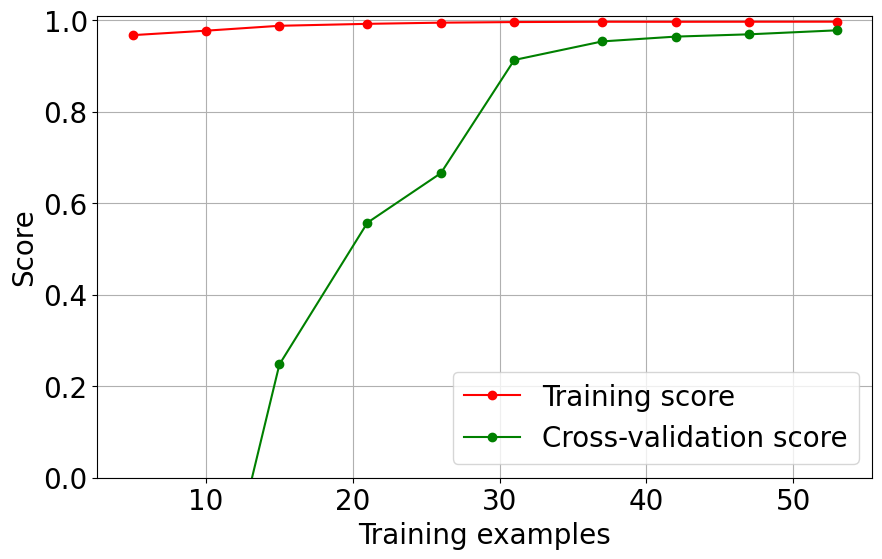

In [9]:
# Step 6.3: Plot Learning Curve
# Plots training vs. validation performance as training size increases.
# Reveals if the model suffers from bias or variance.
# Helps confirm if adding data improves learning.

from sklearn.model_selection import learning_curve
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)

estimator = kr

def plot_learning_curve(estimator,X,y,ylim=None,cv=cv,n_jobs=1,train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=(10,6))
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
        
        
    plt.legend(loc='upper left',fontsize=20)
    plt.xlabel('Experimental',fontsize=20)
    plt.ylabel('ML predicted',fontsize=20)
    #plt.title(" KRR Validation (MAE:{:0.4f}, R2:{:0.4f})".format( ame, score_rr),fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
  
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.legend(loc='best',fontsize=20)
    return plt

   


plot_learning_curve(estimator,X_XRD, y_XRD, ylim=(0, 1.01), cv=cv, n_jobs=1)
#plt.savefig('/home/ashwini/Plateau_2023/Latex/Fig/Mg_XRD_LC.png',format='png',dpi=800, bbox_inches='tight')
plt.show()
   

   k  mean_mae   std_mae  mean_mse   std_mse   mean_r2    std_r2
0  2  0.170822  0.006844  0.063384  0.011544  0.931665  0.001601
1  3  0.125581  0.044526  0.047361  0.043525  0.944859  0.054133


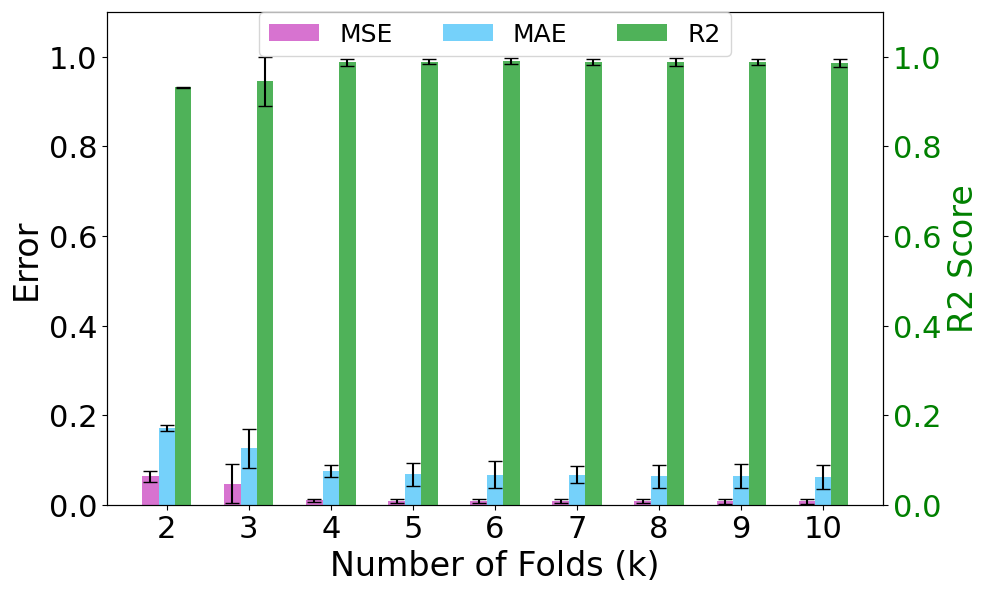

In [10]:
# Step 6.4: Evaluate Model for Different K Values
# Run multiple K-fold validations (for K = 2 → 10)
# to see how error metrics change with the number of folds.
# Calculates and stores:
# Mean and standard deviation of MAE, MSE, R²
# Results are stored in a DataFrame (results_df).
# Define metrics and storage

# Visualize Cross-Validation Metrics
# Create a bar plot showing:
# MAE and MSE (left y-axis)
# R² (right y-axis)
# for each k value.
# This helps compare model stability as the number of folds varies.

scoring = {
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2'
}
k_values = np.arange(2,11,1)
results = []

# Iterate over different k values
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Run cross-validation once for all metrics
    cv_results = cross_validate(kr, X_XRD, y_XRD, cv=kf, scoring=scoring)
    
    # Compute mean and std for each metric
    mean_mae = -np.mean(cv_results['test_mae'])
    std_mae = np.std(cv_results['test_mae'])
    mean_mse = -np.mean(cv_results['test_mse'])
    std_mse = np.std(cv_results['test_mse'])
    mean_r2 = np.mean(cv_results['test_r2'])
    std_r2 = np.std(cv_results['test_r2'])
    
    # Store results in a structured format
    results.append({
        'k': k,
        'mean_mae': mean_mae,
        'std_mae': std_mae,
        'mean_mse': mean_mse,
        'std_mse': std_mse,
        'mean_r2': mean_r2,
        'std_r2': std_r2
    })

# Convert to DataFrame for easy plotting and analysis
results_df = pd.DataFrame(results)
print(results_df.head(2))

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.xticks(k_values, k_values, fontsize=22)
# Bar plot with error bars for Mean Absolute Error (MAE)
bar_width = 0.2
ax1.set_ylim(0, 1.1)
k_values_shifted = k_values - bar_width
ax1.bar(k_values_shifted, results_df['mean_mse'], width=bar_width, yerr=results_df['std_mse'], capsize=5, color='#C738BD', alpha=0.7, label='MSE')
ax1.bar(k_values, results_df['mean_mae'], width=bar_width, yerr=results_df['std_mae'], capsize=5, color='#3ABEF9', alpha=0.7, label='MAE')
ax1.set_xlabel('Number of Folds (k)', fontsize=24)
ax1.set_ylabel('Error', fontsize=24)
ax1.tick_params(axis='y', labelsize=22)

ax2 = ax1.twinx()
ax2.set_ylim(0, 1.2)
ax2.bar(k_values + bar_width, results_df['mean_r2'], width=bar_width, yerr=results_df['std_r2'], capsize=5, color='#059212', alpha=0.7, label='R2')
ax2.set_ylabel('R2 Score', color='g', fontsize=24)
ax2.tick_params(axis='y', labelcolor='g', labelsize=22)
plt.ylim(0,1.1)

# Add legend
fig.legend(loc='upper center',shadow=False, ncol=3, fontsize=18)

plt.tight_layout()
#plt.savefig('OUTPUT/KRR_ML_K-fold.png',format='png',dpi=800, bbox_inches='tight')
plt.show()

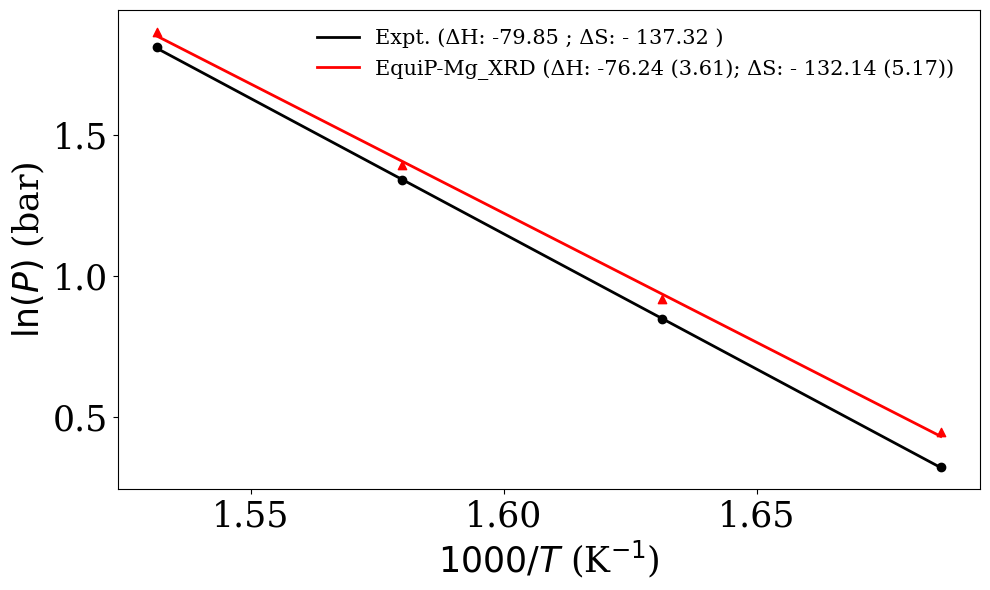

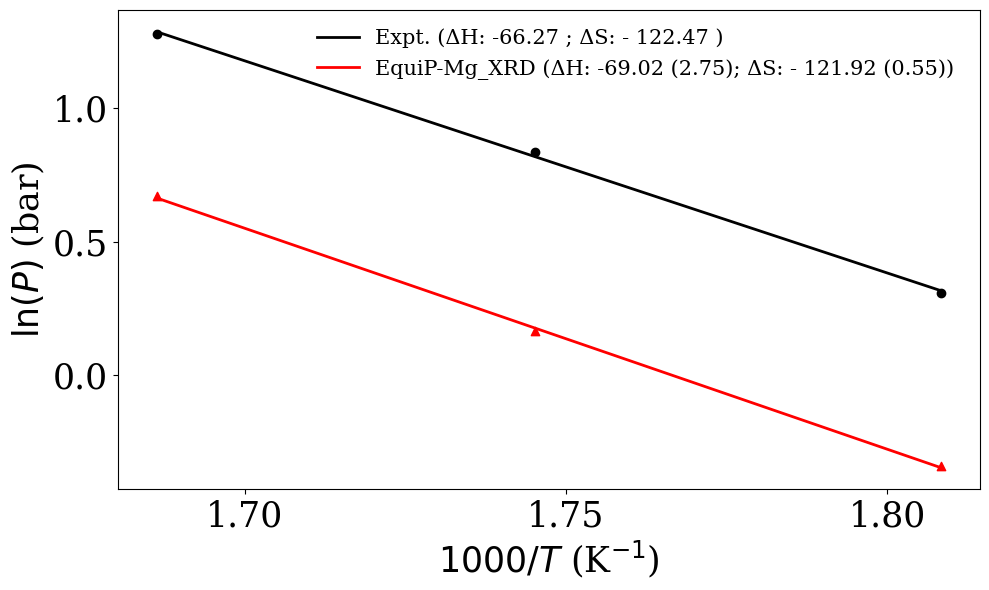

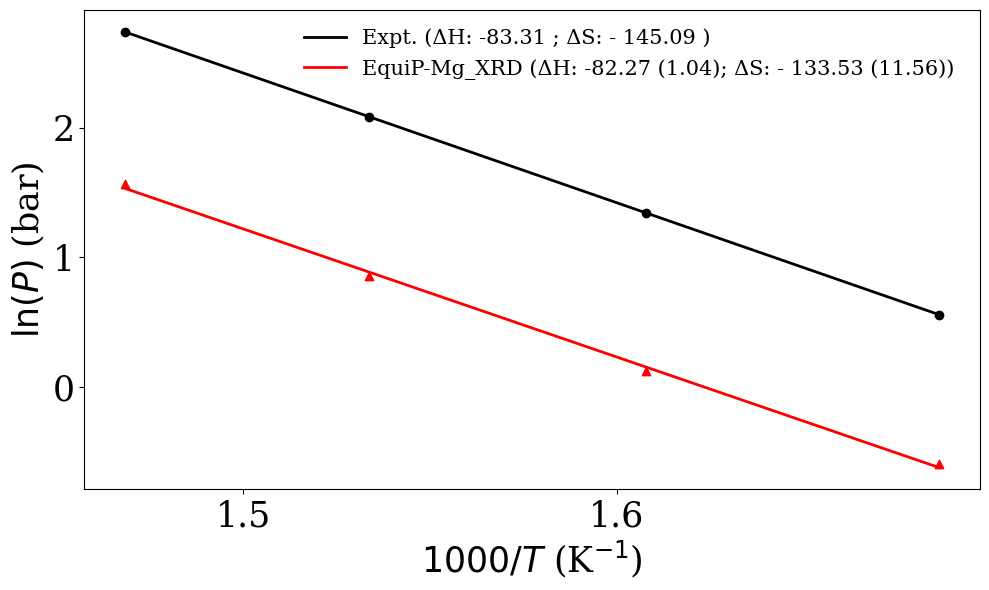

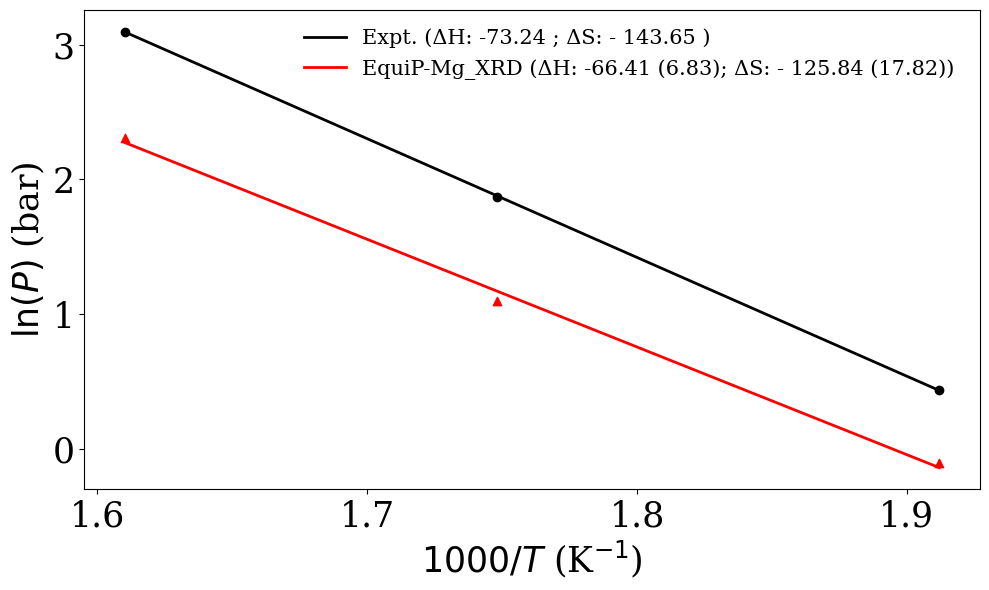

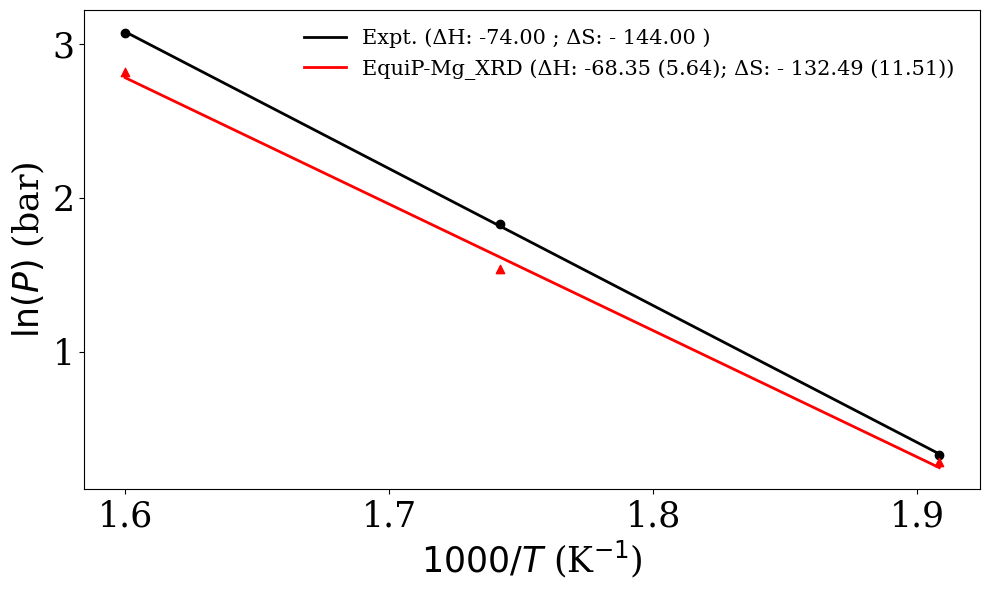

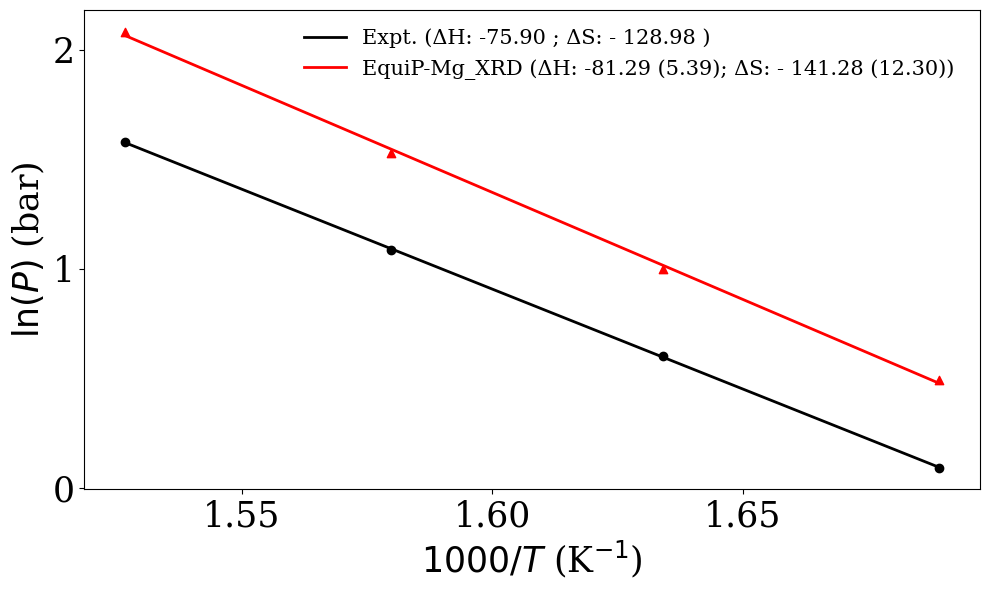

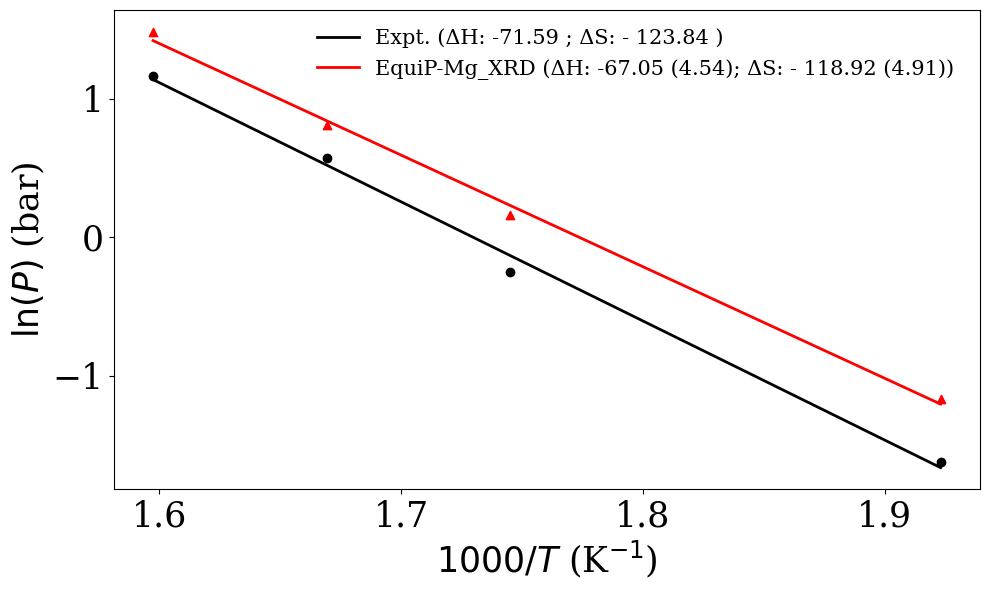

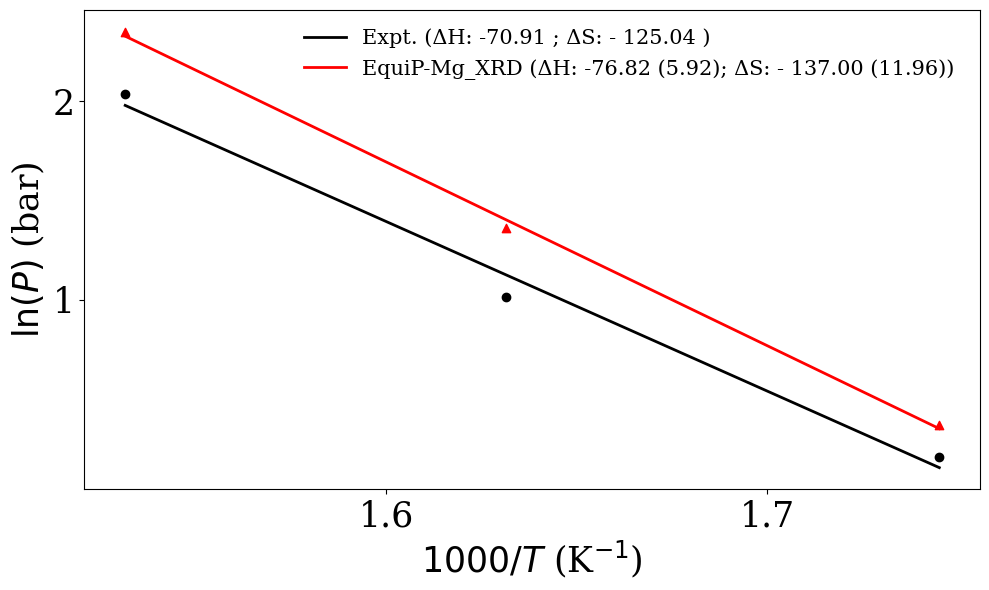

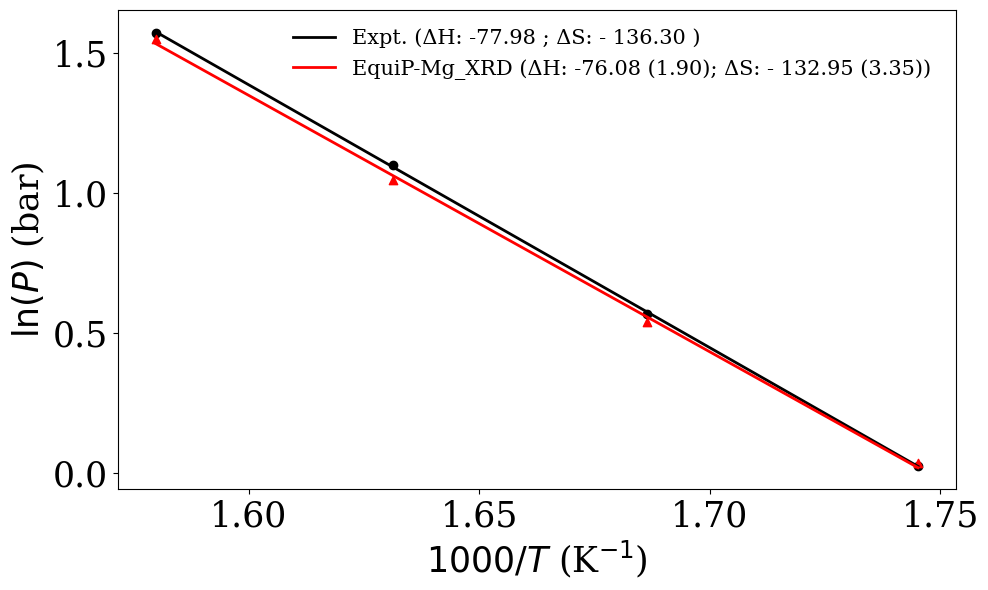

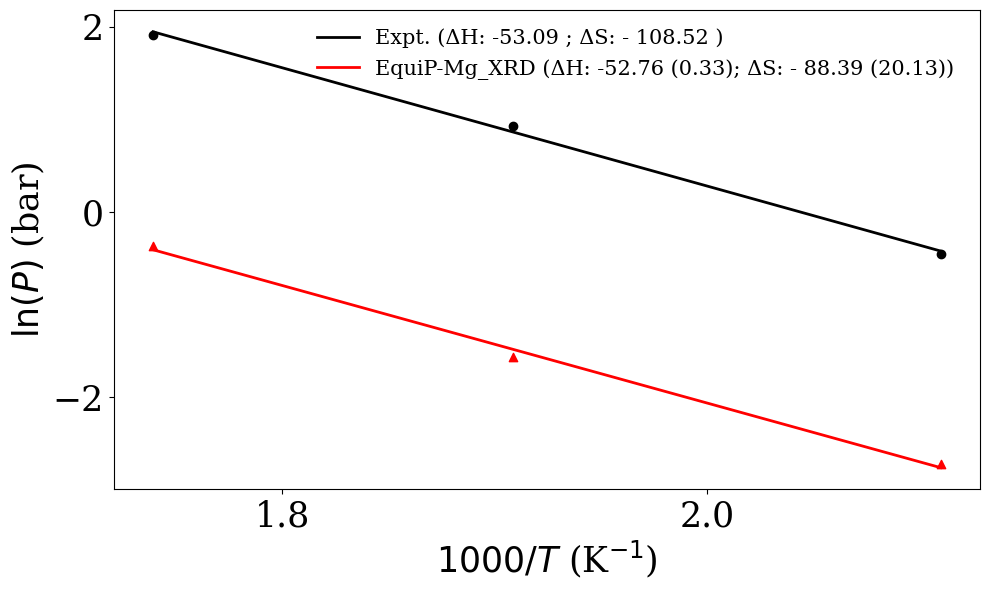

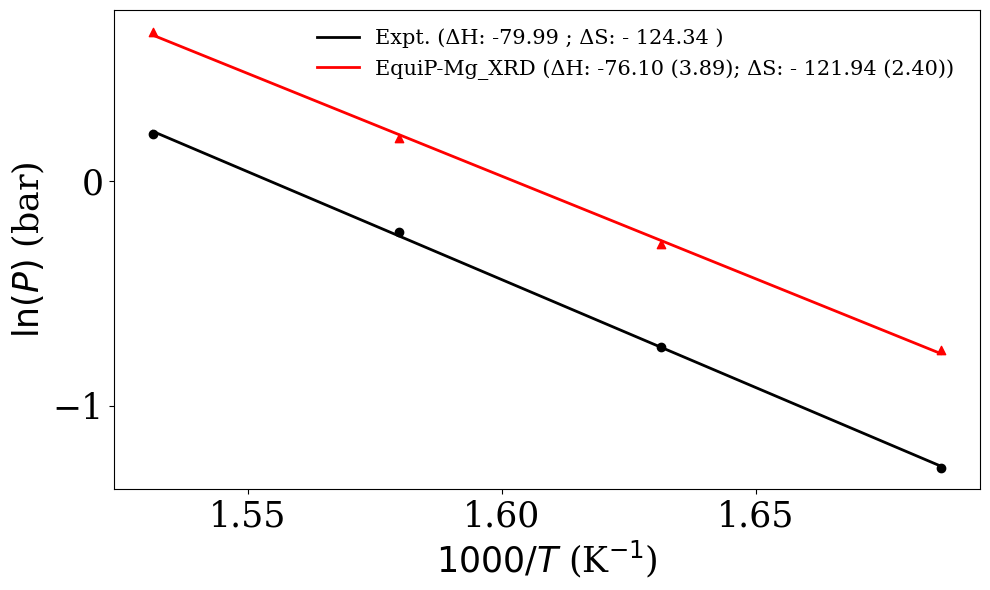

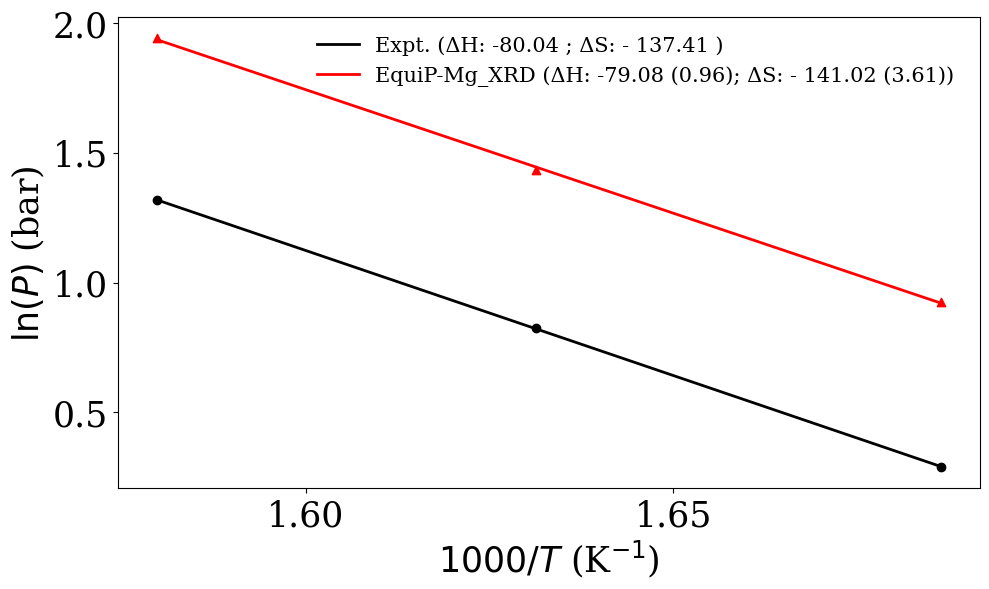

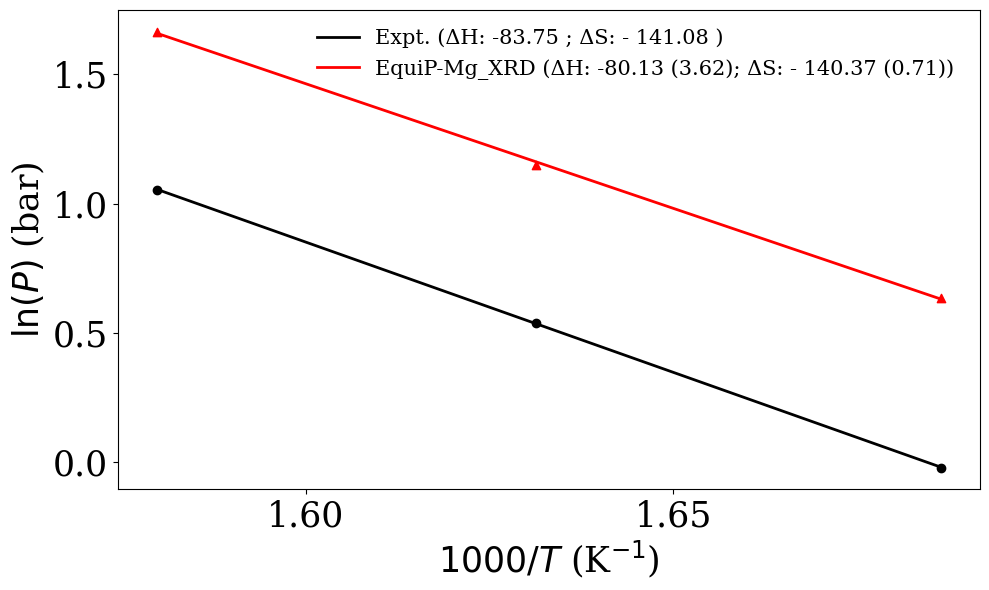

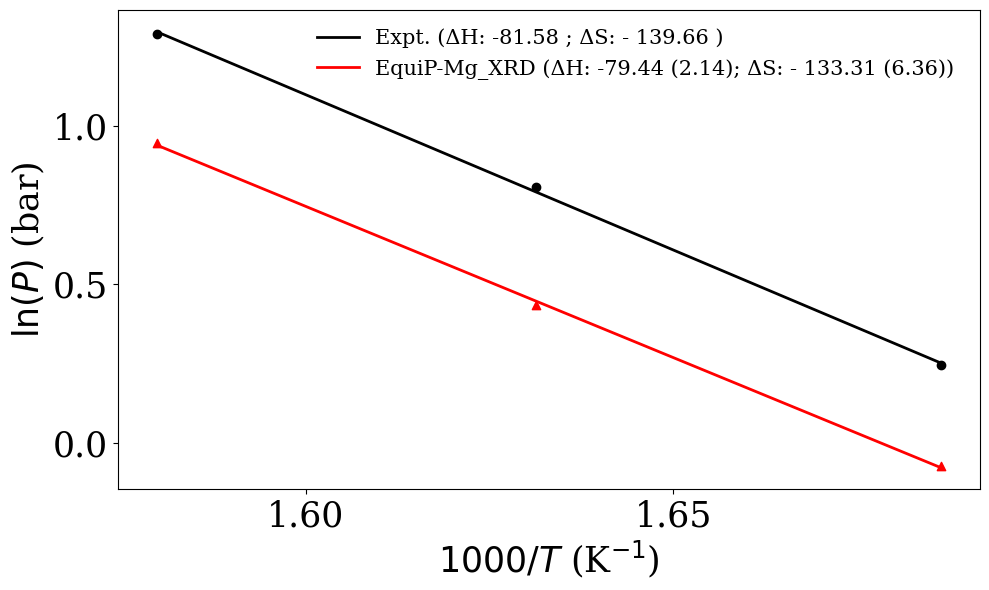

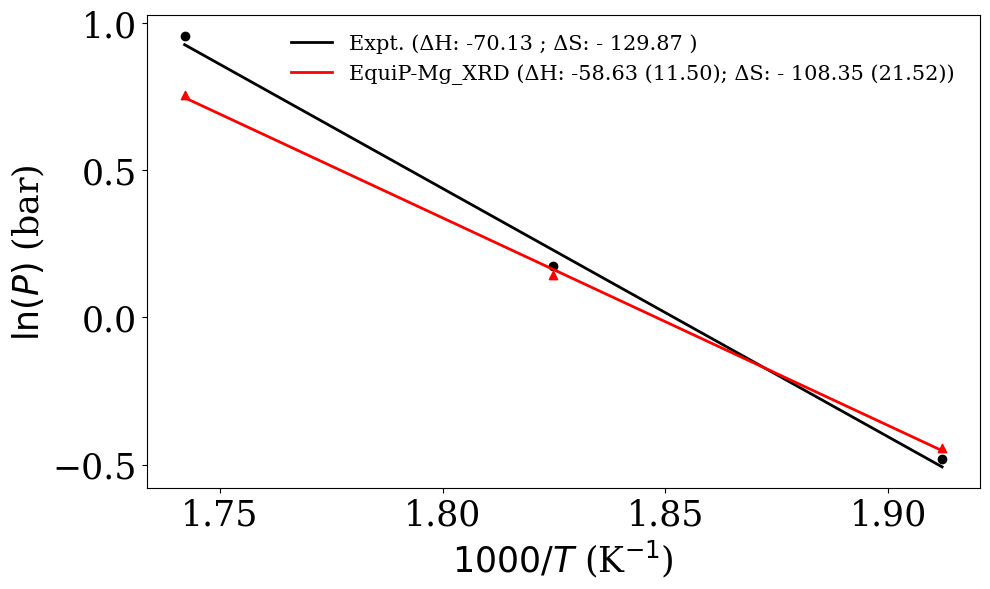

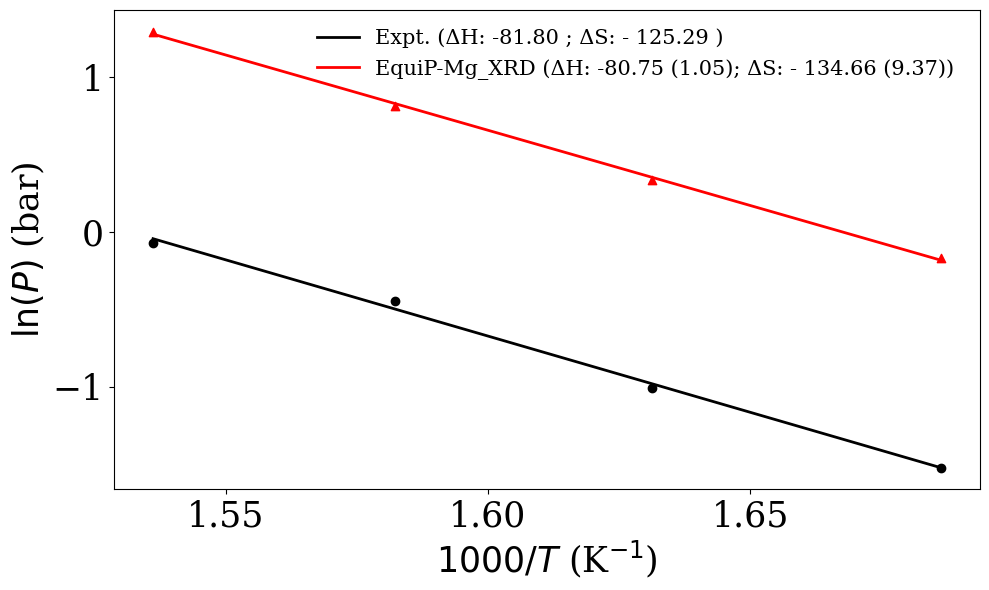

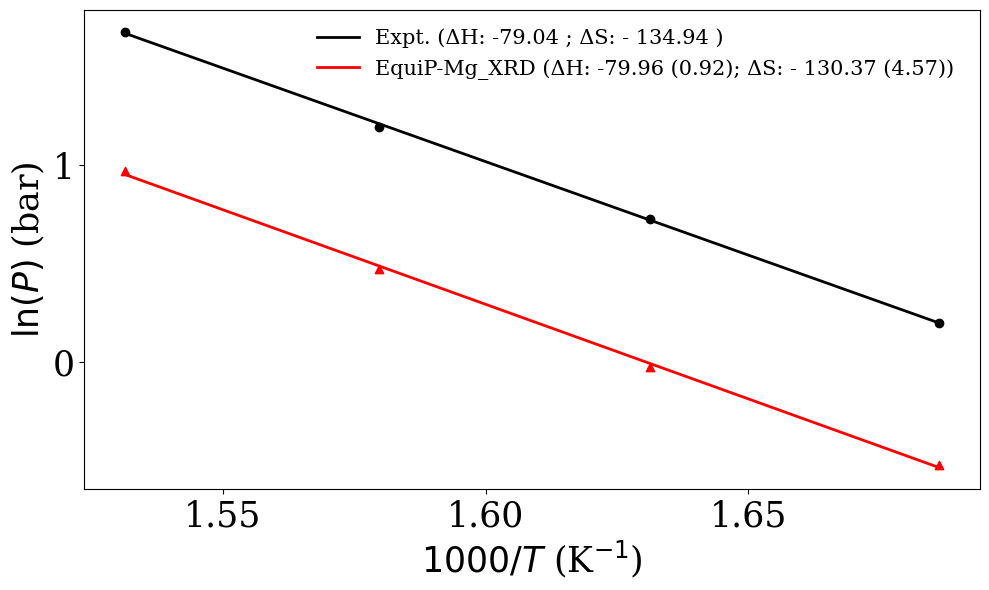

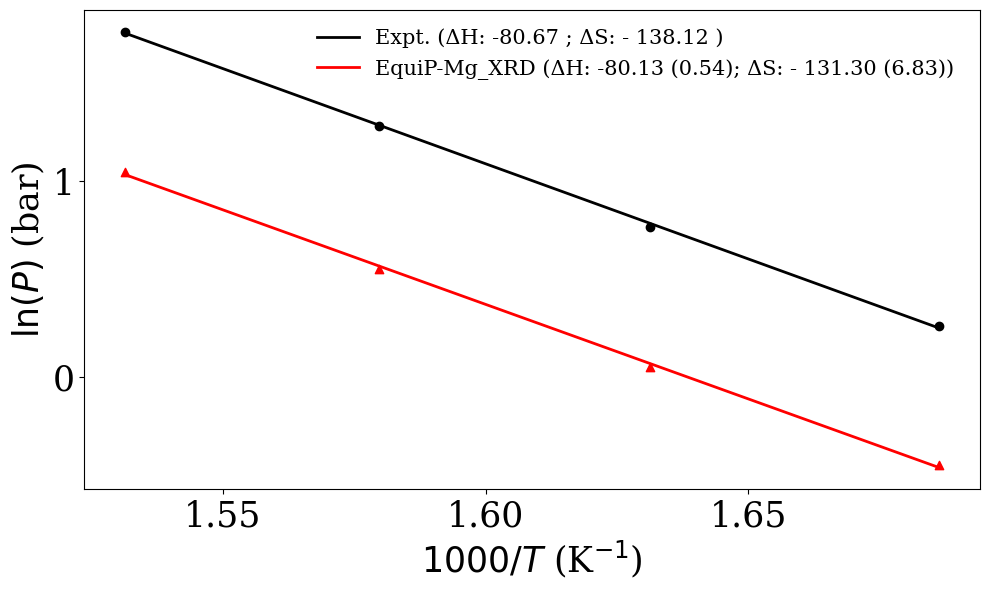

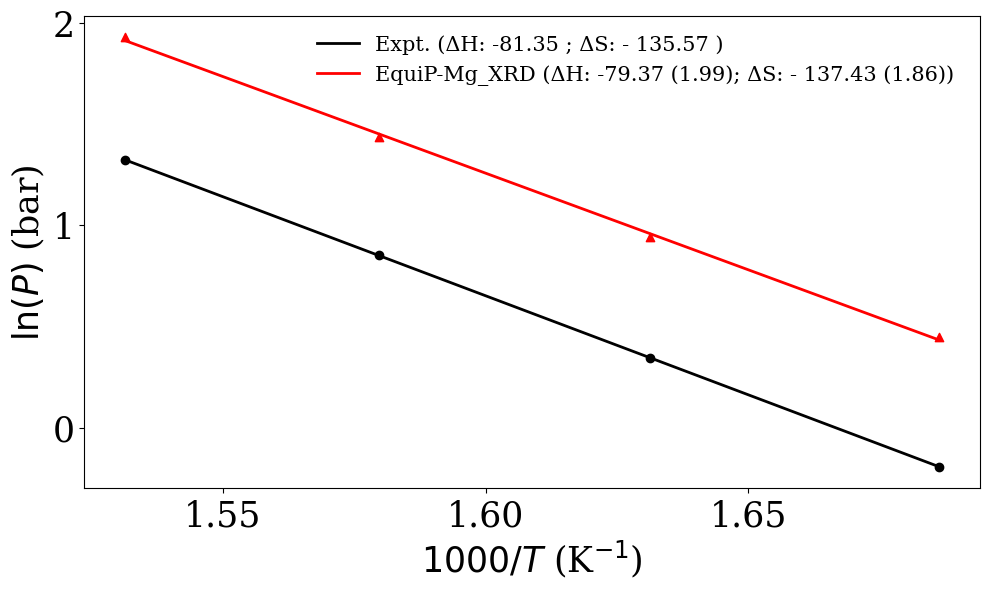

In [11]:
#Step 7: Leave-One-Composition-Out (LOCO) Analysis
# Iteratively removes one composition from training
# train model on n-1 compositions 
# Predicts Peq for removed composition using the rest of the data
# Compares predicted vs. experimental P–T relationships
# Estimates ΔH (enthalpy) and ΔS (entropy) via Van’t Hoff fits
# Plots are generated showing both experimental and model-predicted trends for each composition.
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

Feature_with_XRD=['Temperature', 'CR',    
       'FIE',  'BM', 'HF', 'MV', 'Mass',  
    'M-H_Bond', 'M-H_Eng',    'formation_H', 
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix', 
      'Top_Intensity_1', 'Top_Intensity_2', 'Top_Intensity_3',
       'Top_Intensity_4', 'Top_Intensity_5', 'Top_Intensity_6',
       'Top_Intensity_7', 'Top_Intensity_8', 'Top_Intensity_9',
       'Top_Intensity_10', 'Corresponding_Angle_1', 'Corresponding_Angle_2',
       'Corresponding_Angle_3', 'Corresponding_Angle_4',
       'Corresponding_Angle_5', 'Corresponding_Angle_6',
       'Corresponding_Angle_7', 'Corresponding_Angle_8',
       'Corresponding_Angle_9', 'Corresponding_Angle_10']

unique_entries = data.drop_duplicates(['composition_final'])
test=data.copy()


for xx in range(0,len(unique_entries)):
    q=unique_entries[xx:xx+1]
    compostion = q['composition_final']
    com=compostion.values[0]
    TEST=data[(data["composition_final"]==com)]
    TRAIN= data.drop(TEST.index)

    X_train1 = TRAIN[Feature_with_XRD]
    y_train1 = TRAIN["Ln(P)_Mpa"]

    #Input and Target
    X_test1 = TEST[Feature_with_XRD]
    y_test1 = TEST["Ln(P)_Mpa"]
    


    clf1=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.001)
    clf1.fit(X_train1, y_train1)
    TEST['ML_KRR']=clf1.predict(X_test1)

    plt.figure(figsize=(10,6))
    plt.rcParams['font.family'] = 'Serif'
    plt.locator_params(nbins=4)
    plt.xticks(fontsize=25,)
    plt.yticks(fontsize=25)
    slope, intercept, _, _, _ = linregress(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['Ln(P)_Mpa'])))
    sl1= slope*8.314
    in1= intercept*8.314
    plt.scatter(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['Ln(P)_Mpa'])), marker='o',color='black')
    plt.plot((1000/(TEST['Temperature_1'])), slope*(1000/(TEST['Temperature_1'])) + intercept, 'ko-', linewidth=2, markersize=0, color='black', label=f'Expt. (ΔH: {sl1:.2f} ; ΔS: - {in1:.2f} )')
    TEST['Exp_Entalpy'] =sl1
    TEST['Exp_Entropy'] =in1
    slope1, intercept1, _, _, _ = linregress(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['ML_KRR'])))
    sl2= slope1*8.314
    in2= intercept1*8.314
    plt.scatter(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['ML_KRR'])),marker='^',color='red')
    plt.plot(1000/(TEST['Temperature_1']), slope1*(1000/(TEST['Temperature_1'])) + intercept1, 'r^-', linewidth=2, markersize=0, label=f'EquiP-Mg_XRD (ΔH: {sl2:.2f} ({np.abs(np.abs(np.abs(sl1)-np.abs(sl2))):.2f}); ΔS: - {in2:.2f} ({np.abs(in1-in2):.2f})) ')
    TEST['ML_Entalpy'] =sl2
    TEST['ML_Entropy'] =in2
    plt.xlabel(r'$1000/T$ (K$^{-1}$)', fontsize=25)
    plt.ylabel(r'$\ln(P)$ (bar)', fontsize=25)
    plt.legend(loc="upper right",frameon=False,fontsize=15)
    plt.tight_layout()
    plt.show()


In [15]:
data_all = pd.read_csv('data/EQUIP_Input.csv')
cols=['Temperature', 'CR',    
       'FIE',  'BM', 'HF', 'MV', 'Mass',  
    'M-H_Bond', 'M-H_Eng',    'formation_H', 
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix']

scalerA = StandardScaler()
data_all[cols] = scalerA.fit_transform(data_all[cols])


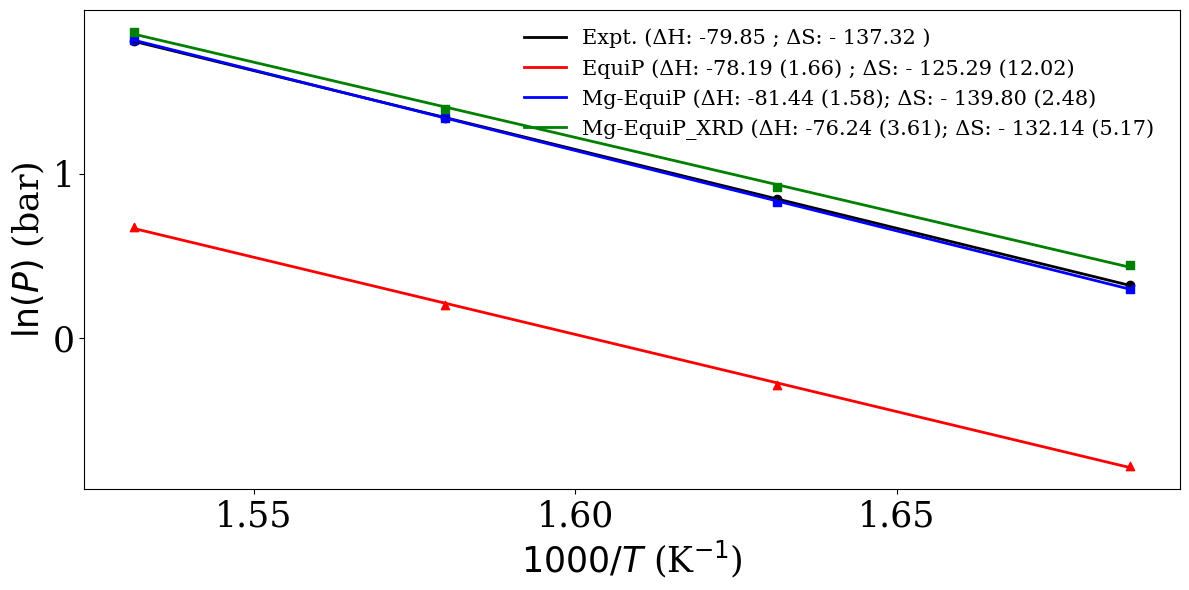

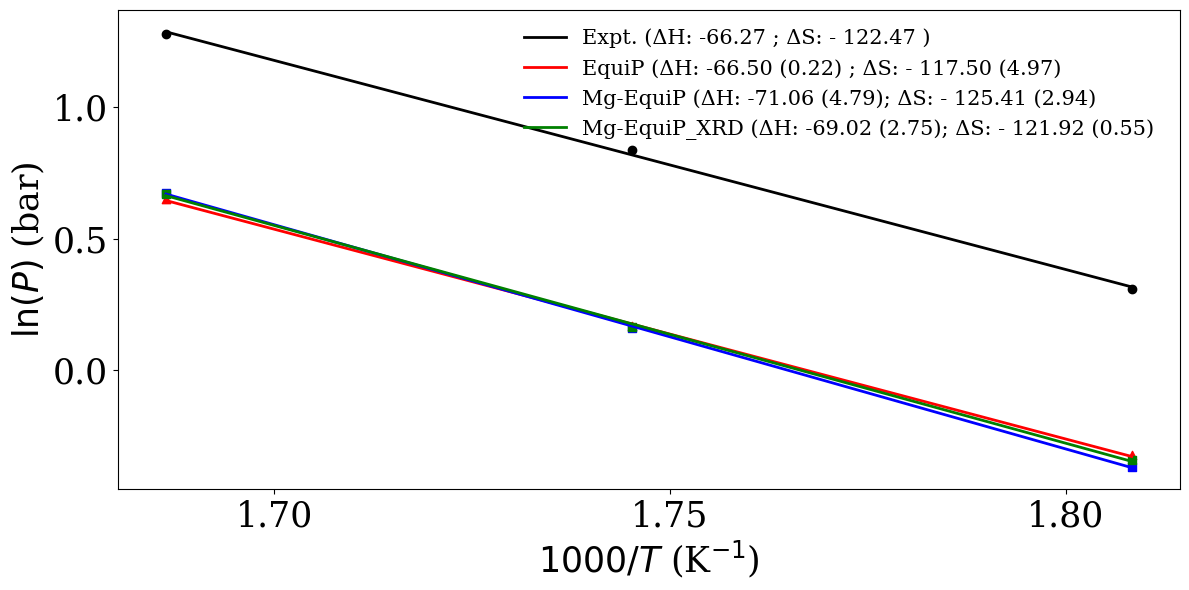

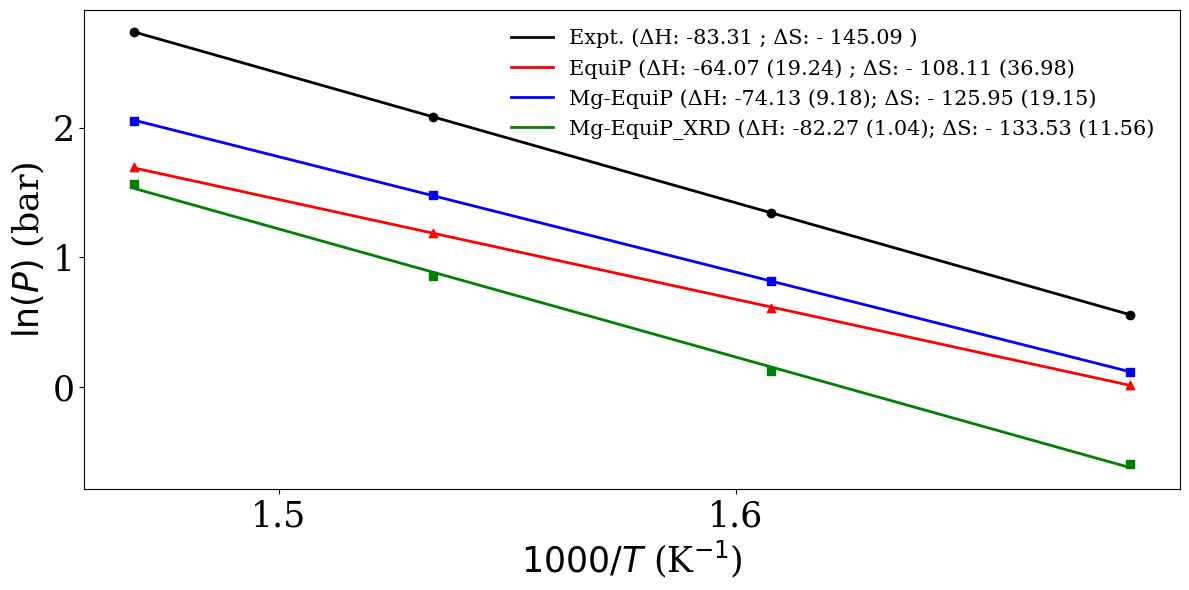

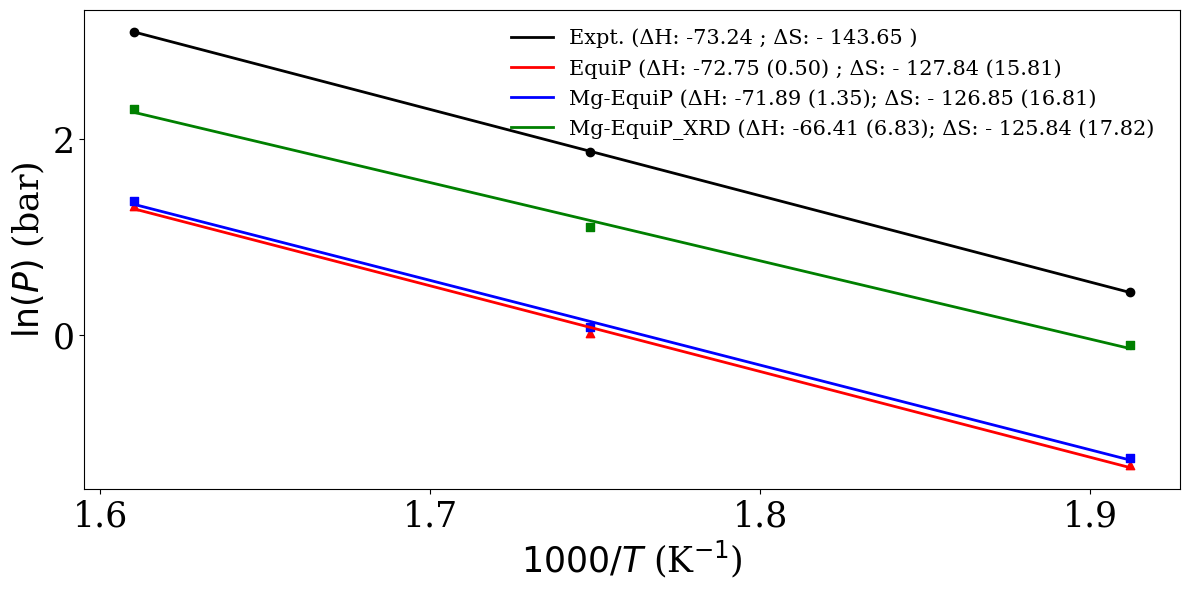

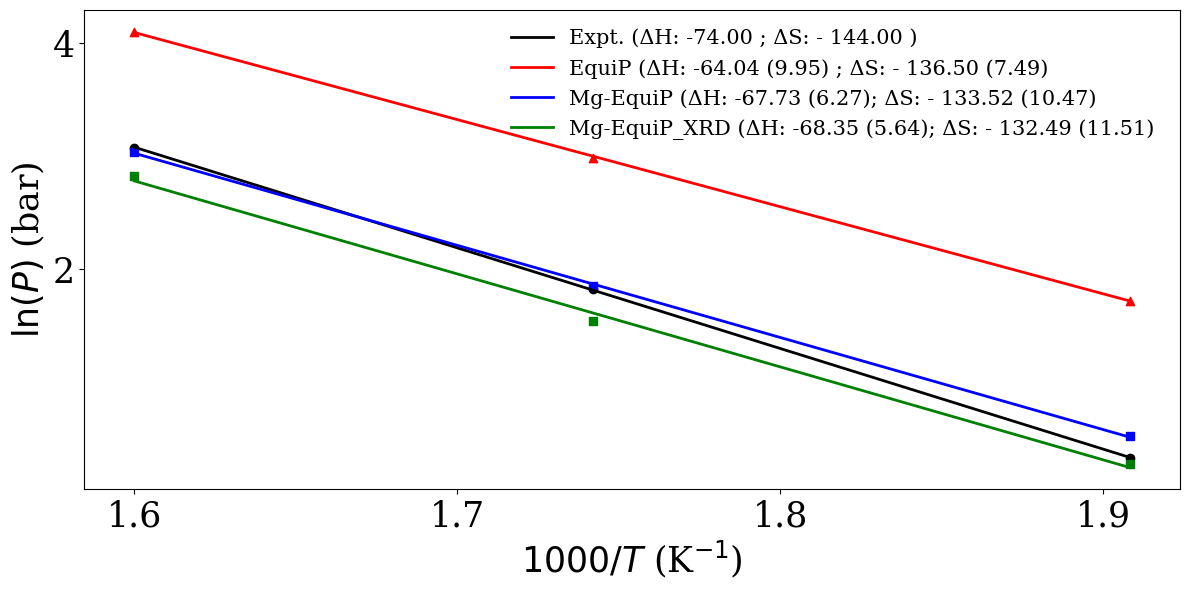

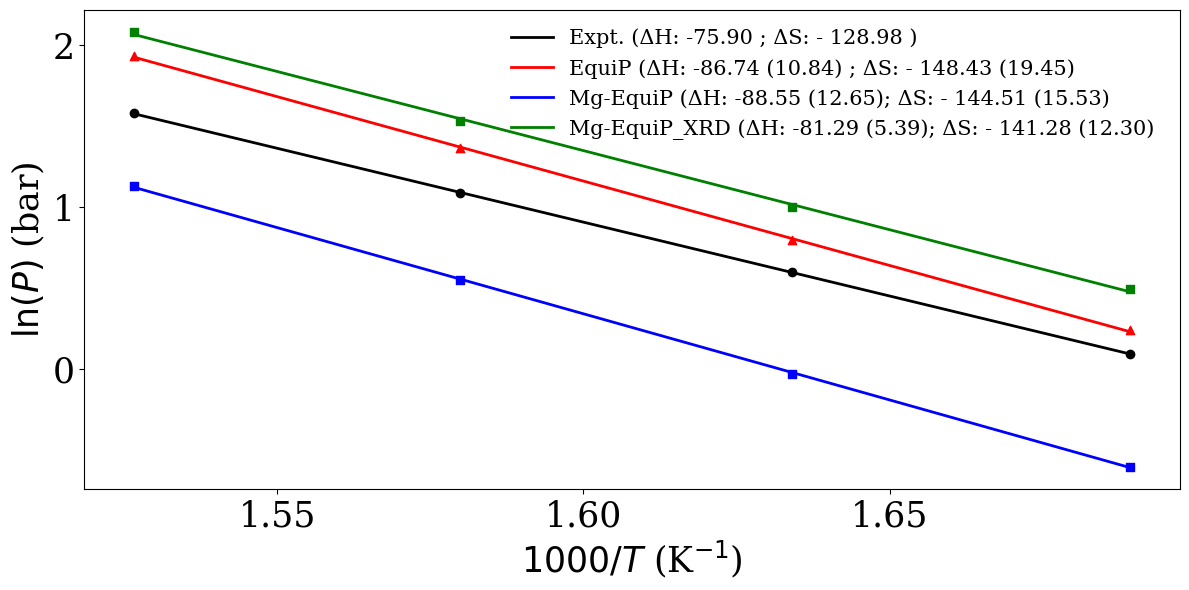

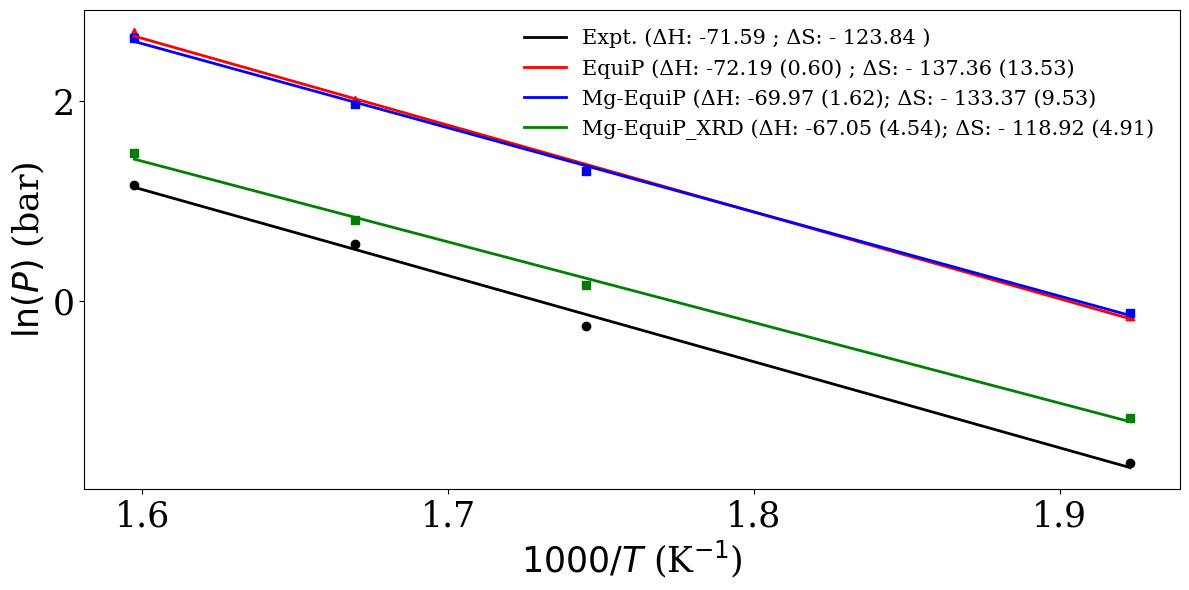

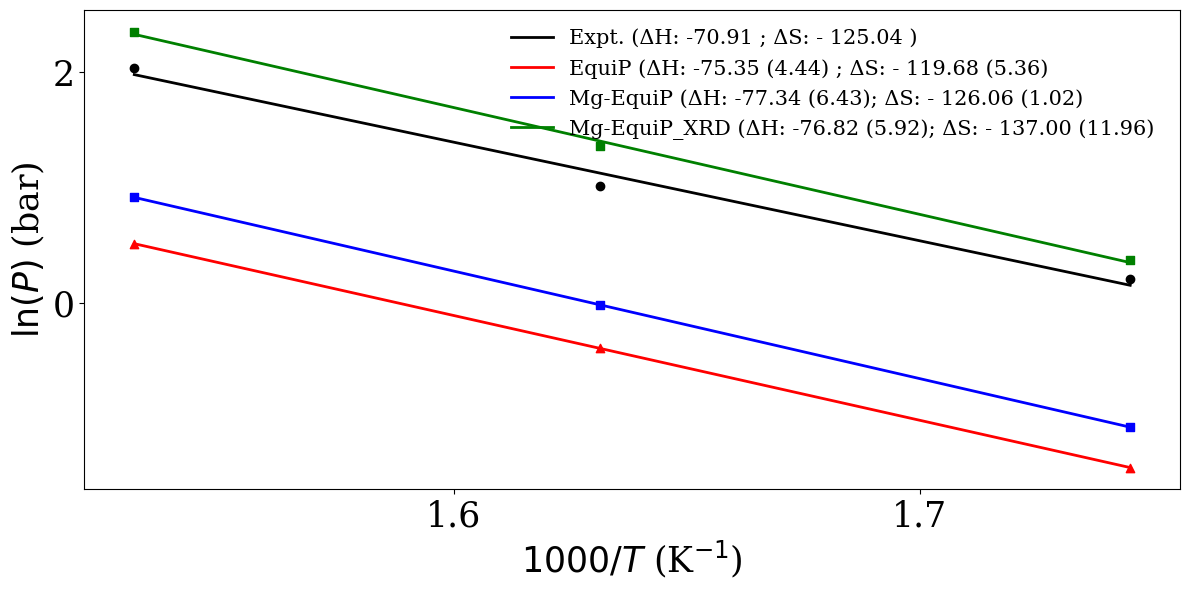

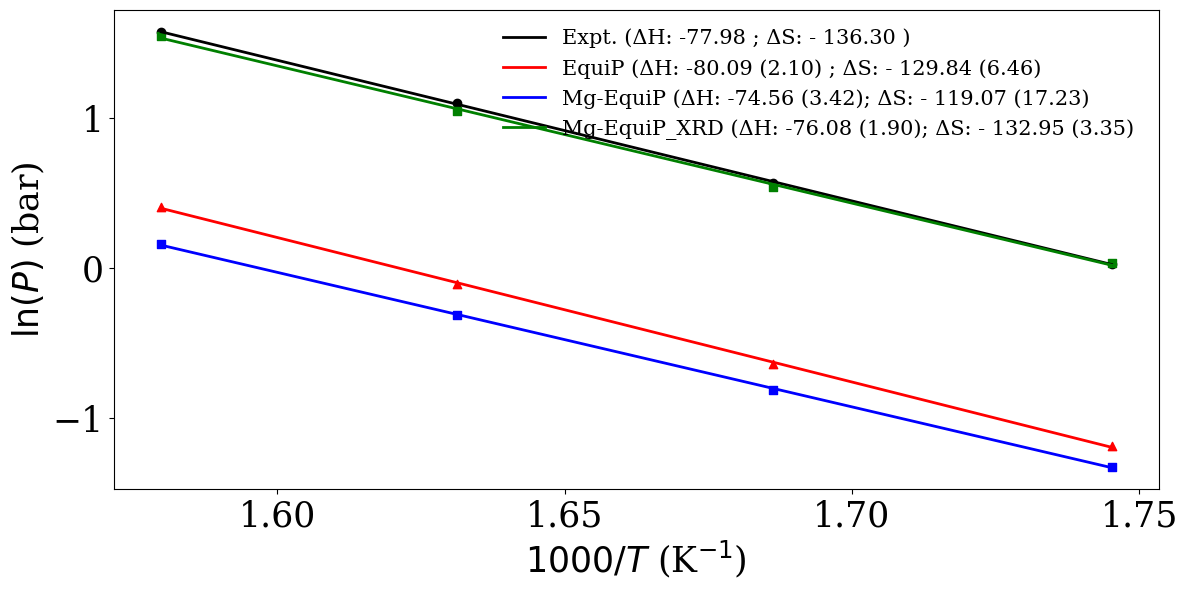

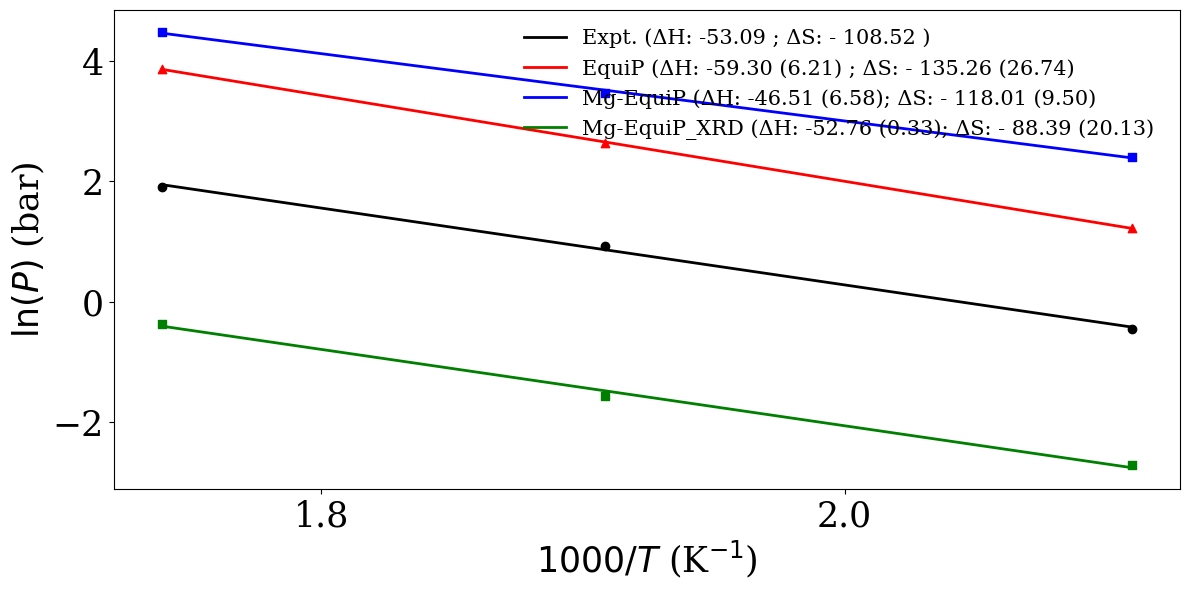

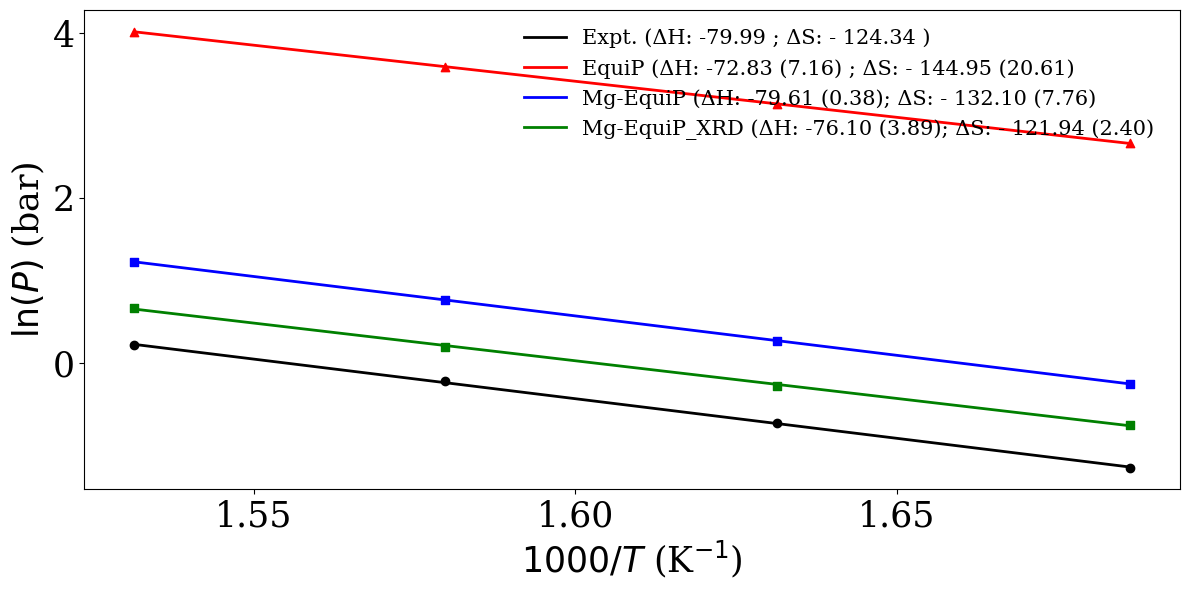

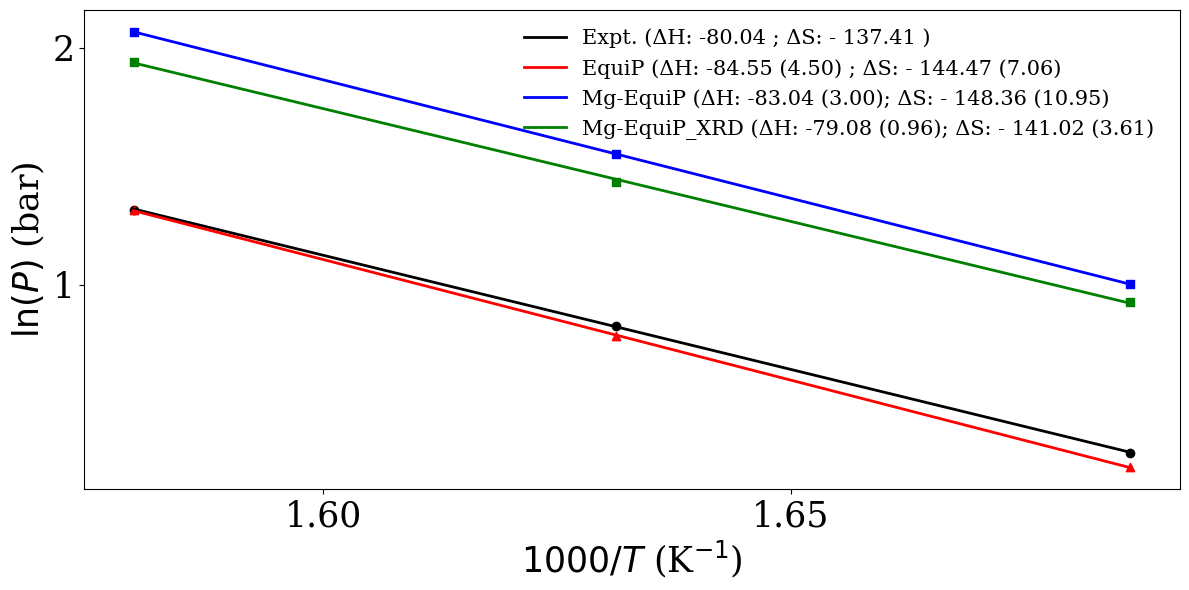

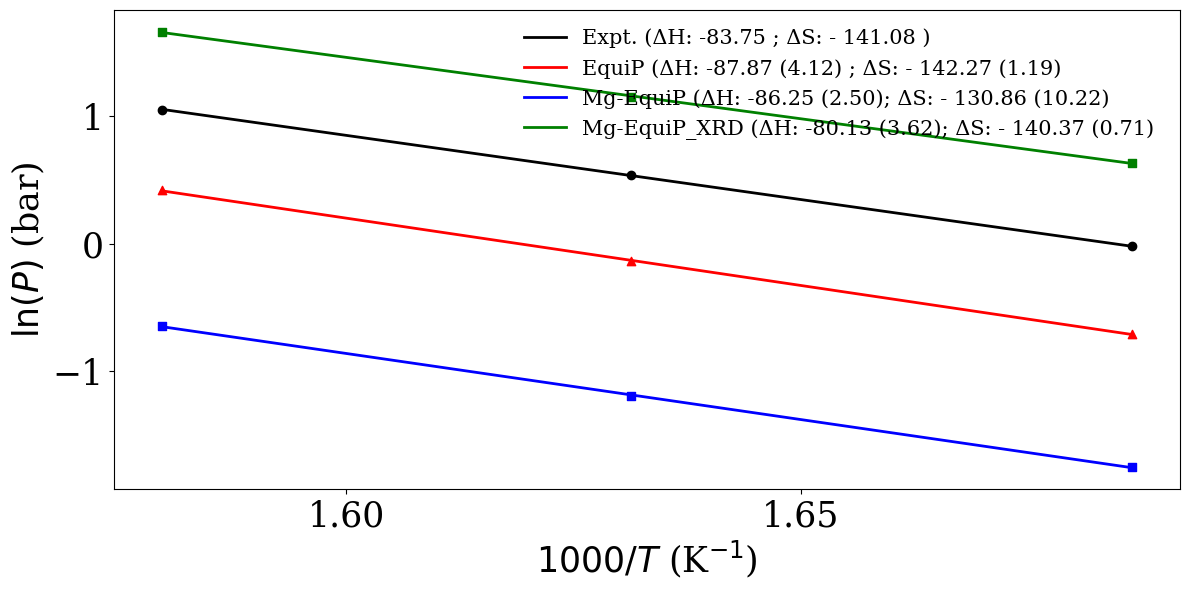

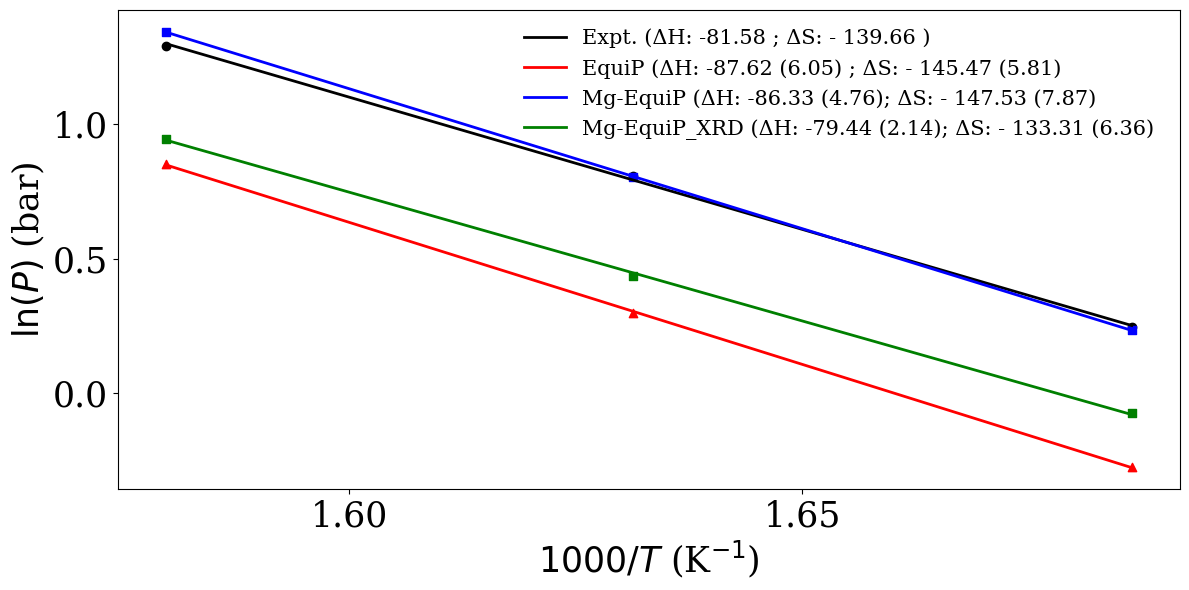

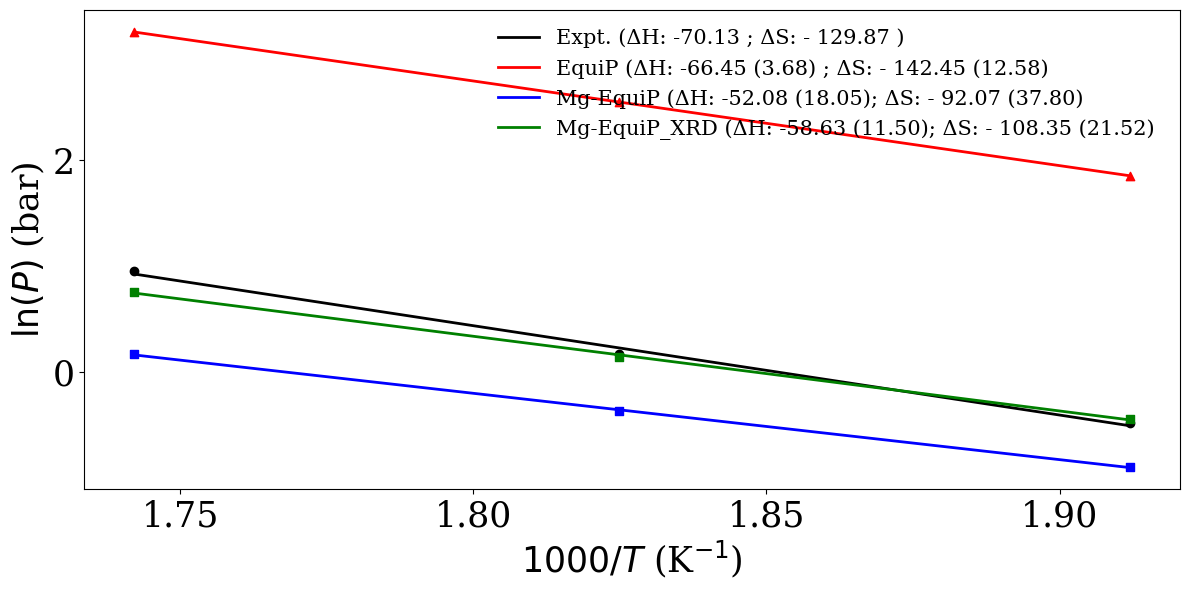

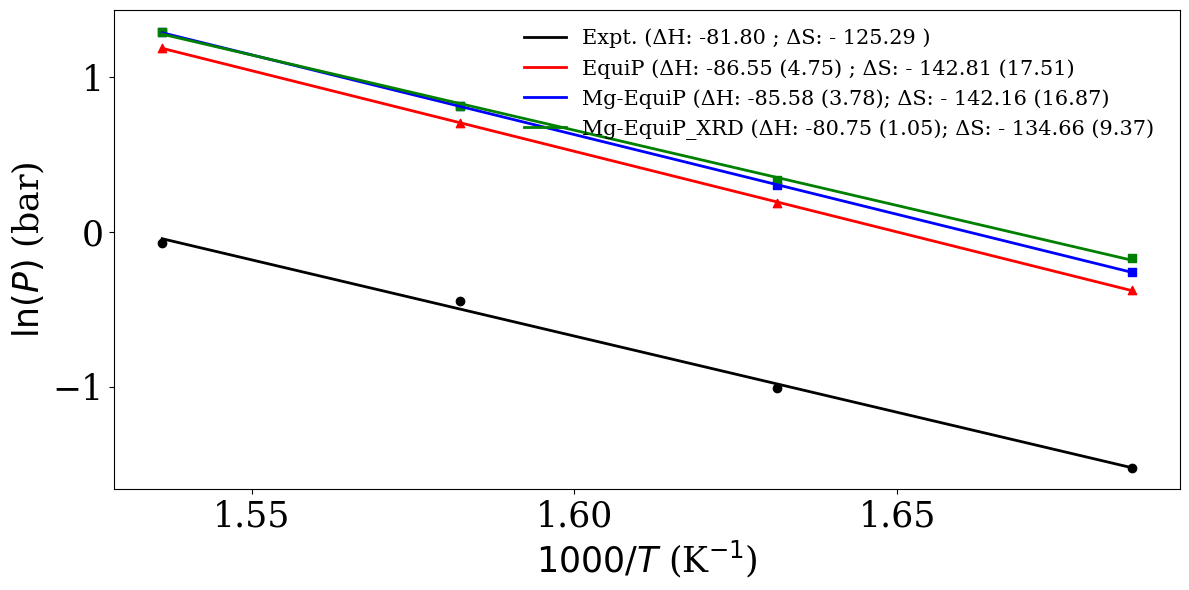

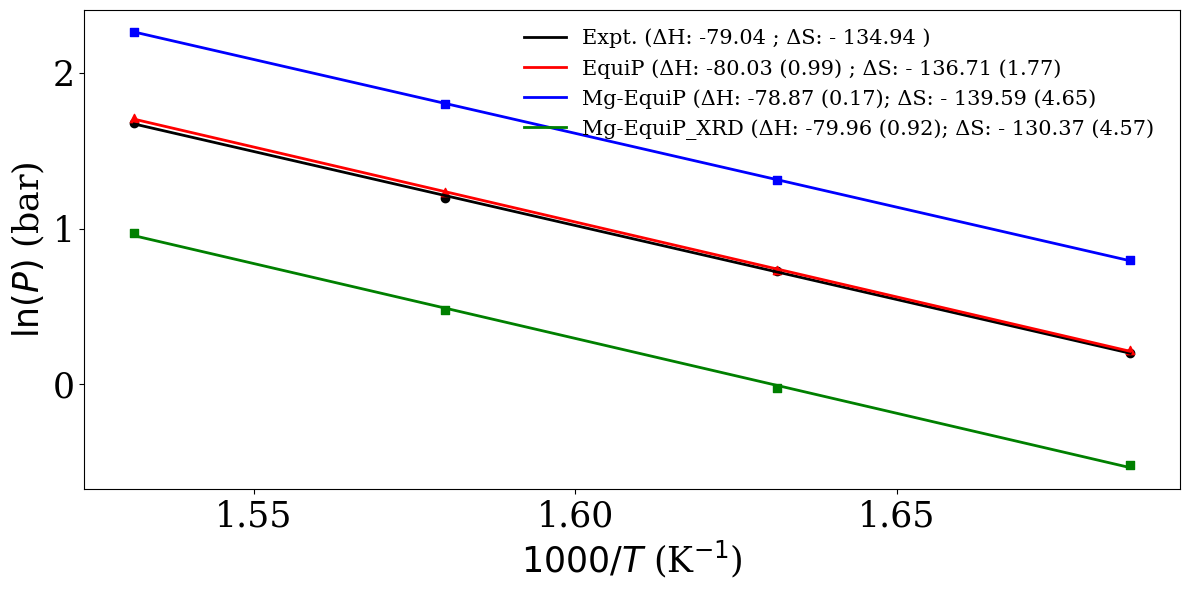

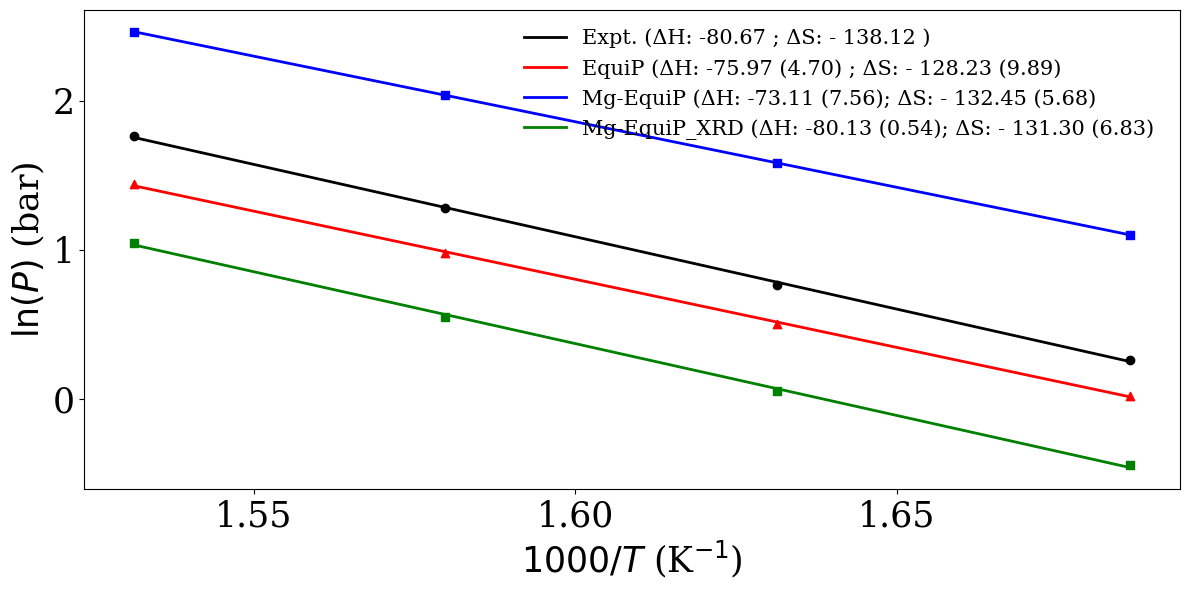

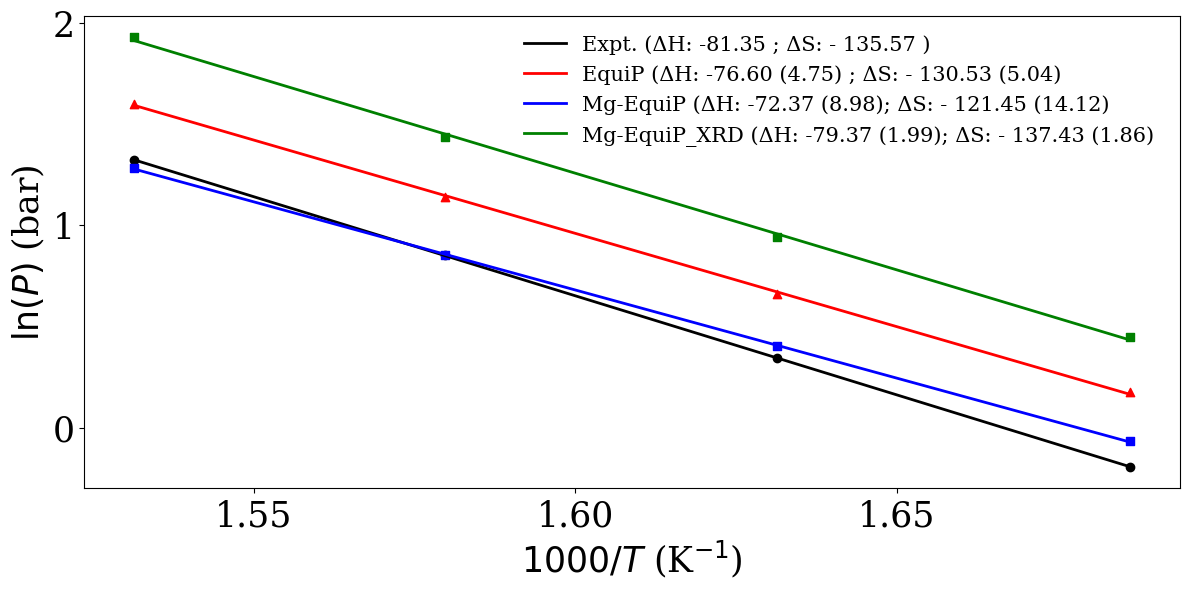

In [16]:
#Step 8: Leave-One-Composition-Out (LOCO) Analysis Comparision EquiP Vs EquiP-Mg Vs EquiP-Mg-XRD


Features=['Temperature', 'CR',    
       'FIE',  'BM', 'HF', 'MV',   'Mass',
    'M-H_Bond', 'M-H_Eng',    'formation_H', 
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix']

Features_with_Mg=['Temperature', 'CR',    
       'FIE',  'BM', 'HF', 'MV',   'Mass',
    'M-H_Bond', 'M-H_Eng',    'formation_H', 
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix','Top_Intensity_1', 'Top_Intensity_2', 'Top_Intensity_3',
       'Top_Intensity_4', 'Top_Intensity_5', 'Top_Intensity_6',
       'Top_Intensity_7', 'Top_Intensity_8', 'Top_Intensity_9',
       'Top_Intensity_10', 'Corresponding_Angle_1', 'Corresponding_Angle_2',
       'Corresponding_Angle_3', 'Corresponding_Angle_4',
       'Corresponding_Angle_5', 'Corresponding_Angle_6',
       'Corresponding_Angle_7', 'Corresponding_Angle_8',
       'Corresponding_Angle_9', 'Corresponding_Angle_10']



unique_entries = data.drop_duplicates(['composition_final'])
for xx in range(0,len(unique_entries)):
    q=unique_entries[xx:xx+1]
    compostion = q['composition_final']
    com=compostion.values[0]
    TEST_Mg=data[(data["composition_final"]==com)]
    TRAIN_Mg= data.drop(TEST_Mg.index)

    TEST_all=data_all[(data_all["composition_final"]==com)]
    TRAIN_all= data_all.drop(TEST_all.index)

    #Train validation split for EquiP with compositional features
    X_train_all = TRAIN_all[Features]
    y_train_all = TRAIN_all["Ln(P)_Mpa"]
    X_test_all = TEST_all[Features]
   # y_test_all = TEST_all["Ln(P)_Mpa"]
    
    krr_all = KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.1)
    krr_all.fit(X_train_all, y_train_all)
    TEST_Mg['ML_All_data']=krr_all.predict(X_test_all)
    
    #Train validation split for EquiP-Mg with compositional features
    X_train_Mg = TRAIN_Mg[Features]
    y_train_Mg = TRAIN_Mg["Ln(P)_Mpa"]
    X_test_Mg = TEST_Mg[Features]
   # y_test_Mg = TEST_Mg["Ln(P)_Mpa"]
    
    krr_Mg=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.01)
    krr_Mg.fit(X_train_Mg, y_train_Mg)
    TEST_Mg['ML']=krr_Mg.predict(X_test_Mg )
    
    #Train validation split for EquiP-Mg-XRD with compositional and XRD features
    X_train_Mg_XRD = TRAIN_Mg[Features_with_Mg]
    y_train_Mg_XRD = TRAIN_Mg["Ln(P)_Mpa"]
    X_test_Mg_XRD = TEST_Mg[Features_with_Mg]
    #y_test_Mg_XRD= TEST_Mg["Ln(P)_Mpa"]
    
    krr_Mg_XRD=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.001)
    krr_Mg_XRD.fit(X_train_Mg_XRD, y_train_Mg_XRD)
    TEST_Mg['ML_XRD']=krr_Mg_XRD.predict(X_test_Mg_XRD)

    
    aa = TEST_Mg.copy()
    aa[['composition_final','Temperature']]=TEST_Mg[['composition_final','Temperature_1']]
 
    

    plt.figure(figsize=(12,6))
    plt.rcParams['font.family'] = 'Serif'
    plt.locator_params(nbins=4)
    plt.xticks(fontsize=25,)
    plt.yticks(fontsize=25)
   # plt.xlim(200,700)
    #plt.ylim(-3,5)
   # plt.yscale('log')
  


    slope, intercept, r_value, p_value, std_err = linregress((1000/(aa['Temperature'])),np.log(10*np.exp(aa['Ln(P)_Mpa'])))
    sl1= slope*8.314
    in1= intercept*8.314
    plt.scatter(1000/(aa['Temperature']),np.log(10*np.exp(aa['Ln(P)_Mpa'])), marker='o',color='black')
    plt.plot((1000/(aa['Temperature'])), slope*(1000/(aa['Temperature'])) + intercept, 'ko-', linewidth=2, markersize=0, color='black', label=f'Expt. (ΔH: {sl1:.2f} ; ΔS: - {in1:.2f} )')


    slope3, intercept3, _, _, _ = linregress(1000/(aa['Temperature']),np.log(10*np.exp(aa['ML_All_data'])))
    sl4= slope3*8.314
    in4= intercept3*8.314
    plt.scatter(1000/(aa['Temperature']),np.log(10*np.exp(aa['ML_All_data'])),marker='^',color='red')
    plt.plot(1000/(aa['Temperature']), slope3*(1000/(aa['Temperature'])) + intercept3, 'r^-', linewidth=2, markersize=0, color='red', label=f'EquiP (ΔH: {sl4:.2f} ({np.abs(np.abs(sl1)-np.abs(sl4)):.2f}) ; ΔS: - {in4:.2f} ({np.abs(in1-in4):.2f})')


  #  slope1, intercept1 = np.polyfit(1000/(aa['Temperature']),aa['ML_KRR'], 1)
    slope1, intercept1, _, _, _ = linregress(1000/(aa['Temperature']),np.log(10*np.exp(aa['ML'])))
    sl2= slope1*8.314
    in2= intercept1*8.314
    plt.scatter(1000/(aa['Temperature']),np.log(10*np.exp(aa['ML'])),marker='s',color='blue')
    plt.plot(1000/(aa['Temperature']), slope1*(1000/(aa['Temperature'])) + intercept1,  linewidth=2, markersize=0, color='blue', label=f'Mg-EquiP (ΔH: {sl2:.2f} ({np.abs(np.abs(sl1)-np.abs(sl2)):.2f}); ΔS: - {in2:.2f} ({np.abs(in1-in2):.2f}) ')


    slope2, intercept2, _, _, _ = linregress(1000/(aa['Temperature']),np.log(10*np.exp(aa['ML_XRD'])))
    sl3= slope2*8.314
    in3= intercept2*8.314
    plt.scatter(1000/(aa['Temperature']),np.log(10*np.exp(aa['ML_XRD'])),marker='s',color='green')
    plt.plot(1000/(aa['Temperature']), slope2*(1000/(aa['Temperature'])) + intercept2,  linewidth=2, markersize=0, color='green', label=f'Mg-EquiP_XRD (ΔH: {sl3:.2f} ({np.abs(np.abs(sl1)-np.abs(sl3)):.2f}); ΔS: - {in3:.2f} ({np.abs(in1-in3):.2f}) ')




    plt.xlabel(r'$1000/T$ (K$^{-1}$)', fontsize=25)
    plt.ylabel(r'$\ln(P)$ (bar)', fontsize=25)
    plt.legend(loc="upper right",frameon=False,fontsize=15)
    plt.tight_layout()

    plt.show()